## LSTM测试

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import date
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth

from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import random
import os
import tensorflow as tf

/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
today = date.today()

In [3]:
# 获取人民币兑英镑汇率（Yahoo symbol: CNYGBP=X）
data = yf.download("CNYGBP=X", start="2015-01-01", end='2025-05-17')
er_df = data[["Close"]].rename(columns={"Close": "CNY/GBP"})
display(er_df.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,CNY/GBP
Ticker,CNYGBP=X
Date,
2025-05-12,0.103947
2025-05-13,0.105330
2025-05-14,0.104299
2025-05-15,0.104600
2025-05-16,0.104400


In [4]:
er_df['inverse'] = 1 / er_df['CNY/GBP', 'CNYGBP=X']

er_df

Price,CNY/GBP,inverse
Ticker,CNYGBP=X,
Date,,
2015-01-01,0.103420,9.669310
2015-01-02,0.103330,9.677731
2015-01-05,0.104920,9.531071
2015-01-06,0.105350,9.492169
2015-01-07,0.106450,9.394082
...,...,...
2025-05-12,0.103947,9.620287
2025-05-13,0.105330,9.493972


In [5]:
policy_df = pd.read_excel("IR.xlsx")
policy_df['rate_diff'] = policy_df['UK'] - policy_df['CN']
model_df = policy_df.copy()

In [6]:
# 确保 Date 是 datetime 类型
model_df['Date'] = pd.to_datetime(model_df['Date'])

# 保留工作日（周一到周五）
df_weekday = model_df[model_df['Date'].dt.dayofweek < 5].copy()

# 按日期排序（可选）
df_weekday = df_weekday.sort_values('Date').reset_index(drop=True)

In [7]:
df_weekday

,Date,UK,CN,rate_diff
0,2015-01-01,0.50,5.6,-5.10
1,2015-01-02,0.50,5.6,-5.10
2,2015-01-05,0.50,5.6,-5.10
3,2015-01-06,0.50,5.6,-5.10
4,2015-01-07,0.50,5.6,-5.10
...,...,...,...,...
2699,2025-05-07,4.25,3.1,1.15
2700,2025-05-08,4.25,3.1,1.15
2701,2025-05-09,4.25,3.1,1.15
2702,2025-05-12,4.25,3.1,1.15


In [8]:
missing_dates = df_weekday[~df_weekday['Date'].isin(er_df.index)]
print(missing_dates['Date'].tail(10))

658    2017-07-11
750    2017-11-16
2609   2025-01-01
2686   2025-04-18
2687   2025-04-21
Name: Date, dtype: datetime64[ns]


In [9]:
# 确保 Date 列格式一致
df_weekday['Date'] = pd.to_datetime(df_weekday['Date']).dt.normalize()

# 筛选 df_weekday 中仅保留那些出现在 er_df['Date'] 中的行
df_weekday_aligned = df_weekday[df_weekday['Date'].isin(er_df.index)].copy()

df_weekday_aligned = df_weekday_aligned.reset_index(drop=True)

In [10]:
df_weekday_aligned

,Date,UK,CN,rate_diff
0,2015-01-01,0.50,5.6,-5.10
1,2015-01-02,0.50,5.6,-5.10
2,2015-01-05,0.50,5.6,-5.10
3,2015-01-06,0.50,5.6,-5.10
4,2015-01-07,0.50,5.6,-5.10
...,...,...,...,...
2694,2025-05-07,4.25,3.1,1.15
2695,2025-05-08,4.25,3.1,1.15
2696,2025-05-09,4.25,3.1,1.15
2697,2025-05-12,4.25,3.1,1.15


In [11]:
df_weekday_aligned.drop(['UK','CN'], axis=1, inplace=True)

In [12]:
er_mid = er_df['inverse'].reset_index(drop=True)
er_mid

0       9.669310
1       9.677731
2       9.531071
3       9.492169
4       9.394082
          ...   
2697    9.620287
2698    9.493972
2699    9.587820
2700    9.560230
2701    9.578544
Name: inverse, Length: 2702, dtype: float64

In [13]:
while len(df_weekday_aligned) < len(er_mid):
    last_date = df_weekday_aligned['Date'].iloc[-1]
    # 获取下一个工作日（跳过周末）
    next_workday = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=1, freq='B')[0]

    new_row = {col: np.nan for col in df_weekday_aligned.columns}
    new_row['Date'] = next_workday
    new_row['rate_diff'] = 1.15

    df_weekday_aligned = pd.concat([df_weekday_aligned, pd.DataFrame([new_row])], ignore_index=True)

In [14]:
df_weekday_aligned['ER'] = er_mid

df_weekday_aligned

,Date,rate_diff,ER
0,2015-01-01,-5.10,9.669310
1,2015-01-02,-5.10,9.677731
2,2015-01-05,-5.10,9.531071
3,2015-01-06,-5.10,9.492169
4,2015-01-07,-5.10,9.394082
...,...,...,...
2697,2025-05-12,1.15,9.620287
2698,2025-05-13,1.15,9.493972
2699,2025-05-14,1.15,9.587820
2700,2025-05-15,1.15,9.560230


In [15]:
df_weekday_aligned['trade_war'] = 0
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2018-03-22') & (df_weekday_aligned['Date'] <= '2018-12-01'), 'trade_war'] = 1
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2025-02-01') & (df_weekday_aligned['Date'] <= '2025-05-12'), 'trade_war'] = 1

In [16]:
df_weekday_aligned

,Date,rate_diff,ER,trade_war
0,2015-01-01,-5.10,9.669310,0
1,2015-01-02,-5.10,9.677731,0
2,2015-01-05,-5.10,9.531071,0
3,2015-01-06,-5.10,9.492169,0
4,2015-01-07,-5.10,9.394082,0
...,...,...,...,...
2697,2025-05-12,1.15,9.620287,1
2698,2025-05-13,1.15,9.493972,0
2699,2025-05-14,1.15,9.587820,0
2700,2025-05-15,1.15,9.560230,0


In [17]:
lstm_df = df_weekday_aligned.dropna()

lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])  # 保证为 datetime 类型
lstm_df = lstm_df.set_index('Date')  # 设置为 index

In [18]:
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 固定 TensorFlow 随机种子
tf.random.set_seed(42)

# 若用GPU，确保 TensorFlow 使用确定性算法
# 注意：这会牺牲一定速度
from tensorflow.keras import backend as K
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [19]:
# Split data into training and testing sets using 80/20 ratio
split_idx = int(len(lstm_df) * 0.75)
train_df = lstm_df.iloc[:split_idx]
test_df = lstm_df.iloc[split_idx:]

# Separate features (X) and target (y)
X_train = train_df # 注意：这里只取特征列
y_train = train_df['ER']
X_test = test_df
y_test = test_df['ER']

# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month
X_train_seq, y_train_seq = [], []
for i in range(lookback, len(X_train_scaled)):
    # sequence of `lookback` feature vectors
    X_train_seq.append(X_train_scaled[i-lookback:i])
    # target is the exchange rate at this time (one month ahead of last input month)
    y_train_seq.append(y_train_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

# Prepare sequences for the test set (using preceding data for initial sequence)
X_test_seq, y_test_seq = [], []
# Concatenate train and test for sequence generation to include trailing train data in initial test sequences
total_X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
total_y = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
train_len = len(X_train_scaled)
for i in range(train_len, len(total_X)):
    if i < lookback:
        continue  # skip until we have enough history
    X_test_seq.append(total_X[i-lookback:i])
    y_test_seq.append(total_y[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Build the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# 改进后的双层 LSTM 架构
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))

# 别忘了这一步！！
model.compile(optimizer='adam', loss='mean_squared_error')

# 然后再训练
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-17 15:04:53.641233: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{nod

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0604 - val_loss: 0.0032
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

Test MSE Loss: 0.000889
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

2025-05-17 15:05:09.349780: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-17 15:05:09.350073: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


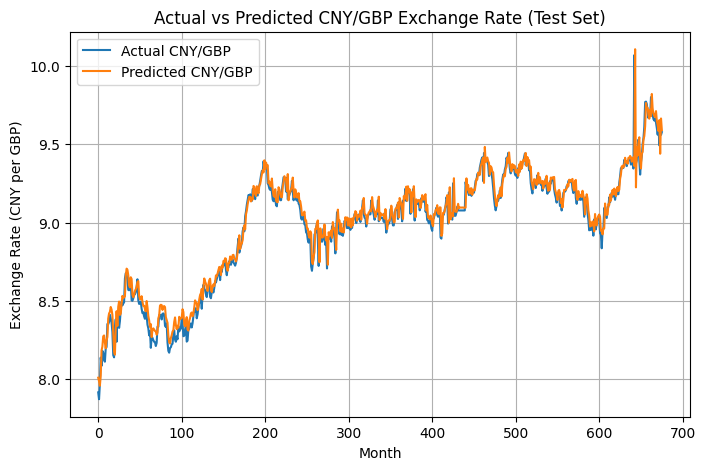

In [20]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test MSE Loss: {test_loss:.6f}")

# Make predictions for the test period
y_pred_scaled = model.predict(X_test_seq)
# Inverse-transform the predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test_seq)

# Visualize the results: Actual vs Predicted exchange rate

plt.figure(figsize=(8,5))
plt.plot(y_actual, label='Actual CNY/GBP')
plt.plot(y_pred, label='Predicted CNY/GBP')
plt.title('Actual vs Predicted CNY/GBP Exchange Rate (Test Set)')
plt.xlabel('Month')
plt.ylabel('Exchange Rate (CNY per GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
pred_df = pd.DataFrame(y_pred)
y_test = y_test.iloc[:-1]
error_cal = pd.DataFrame({})
error_cal['pred'] = pred_df
y_mid = y_test.reset_index(drop=True)
error_cal['actual'] = y_mid
error_cal['error'] = error_cal['pred'] - error_cal['actual']

In [22]:
error_cal

,pred,actual,error
0,8.007694,7.913834,0.093860
1,7.985423,7.869988,0.115435
2,7.956203,7.968191,-0.011988
3,8.021517,8.136167,-0.114650
4,8.182240,8.083356,0.098884
...,...,...,...
671,9.585344,9.620287,-0.034943
672,9.655064,9.493972,0.161092
673,9.440050,9.587820,-0.147769
674,9.665652,9.560230,0.105423


In [23]:
# 计算实际值和预测值的变化趋势（相邻天数差）
actual_diff = error_cal['actual'].diff()
pred_diff = error_cal['pred'].diff()

# 判断趋势是否一致（同为正或同为负 → 相乘大于0）
trend_correct = (actual_diff * pred_diff) > 0

# 去除第一个 NaN（因为 diff 会在第一行生成 NaN）
trend_correct = trend_correct[1:-1]

# 计算正确比例
trend_accuracy = trend_correct.sum() / len(trend_correct)

# 输出
print(f"📈 趋势判断正确的比例为: {trend_accuracy:.2%}")


📈 趋势判断正确的比例为: 48.96%


In [24]:
threshold = 0.05
proportion = (error_cal['error'].abs() > threshold).mean()

print(f"误差大于 0.05 的比例为：{proportion:.2%}")

误差大于 0.05 的比例为：33.58%


## 使用全部数据进行训练，预测未来汇率

In [25]:
train_df = lstm_df

X_train_all = train_df
y_train_all = train_df['ER']

# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled_all = feature_scaler.fit_transform(X_train_all)
y_train_scaled_all = target_scaler.fit_transform(y_train_all.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month
X_train_seq_all, y_train_seq_all = [], []
for i in range(lookback, len(X_train_scaled_all)):
    # sequence of `lookback` feature vectors
    X_train_seq_all.append(X_train_scaled_all[i-lookback:i])
    # target is the exchange rate at this time (one month ahead of last input month)
    y_train_seq_all.append(y_train_scaled_all[i])
X_train_seq_all = np.array(X_train_seq_all)
y_train_seq_all = np.array(y_train_seq_all)

# Build the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# 改进后的双层 LSTM 架构
model_all = Sequential()
model_all.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train_seq_all.shape[2])))
model_all.add(Dropout(0.2))
model_all.add(LSTM(32))
model_all.add(Dense(1))

# 别忘了这一步！！
model_all.compile(optimizer='adam', loss='mean_squared_error')

# 然后再训练
history = model_all.fit(X_train_seq_all, y_train_seq_all, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0310 - val_loss: 0.0023
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 12/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [26]:
test_loss_all = model_all.evaluate(X_train_seq_all, y_train_seq_all, verbose=0)
print(f"Test MSE Loss: {test_loss_all:.6f}")

Test MSE Loss: 0.000773


2025-05-17 15:05:29.525756: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-17 15:05:29.525945: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [27]:
recent_data = lstm_df.iloc[-lookback:]  # 最新 lookback 天的数据
recent_scaled = feature_scaler.transform(recent_data)
# 2. 重塑成 LSTM 所需的形状: (1, lookback, num_features)
X_input = recent_scaled.reshape(1, lookback, recent_scaled.shape[1])

# 3. 进行预测（预测的是缩放后的值）
scaled_prediction = model_all.predict(X_input)[0][0]

# 4. 反缩放，得到实际汇率预测值
predicted_er = target_scaler.inverse_transform([[scaled_prediction]])[0][0]

# 5. 输出
print(f"📈 预测明日的人民币/英镑汇率为：{predicted_er:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
📈 预测明日的人民币/英镑汇率为：9.5989
